# Building a Credit Classification Model using Logistic Regression

This Python notebook uses data from Lending Club, an online peer-to-peer credit marketplace. We take over 24,000 rows of customer data and attempt to build a credit model using a supervised machine learning technique.

---

## Contents
1. Data Preparation
2. Exploratory Data Analysis
3. Predictive Modelling
    * Preprocessing
    * Logistic Regression
    * Tuning
4. Conclusions

---

## Data Preparation

Let's start by importing the required libraries.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

Read the raw data from a .csv file into a Pandas dataframe. Pandas is a powerful library in Python that allows us to manipulate and analyse data.

In [2]:
df = pd.read_csv('data/LendingClub.csv')
df.head()

,Loan Amount,Loan Term,Employment Length,Home Ownership,Annual Income,Loan Purpose,Address State,Debt To Income Ratio,No. Delinquencies In Last 2 Years,Earliest Credit Line Opened,...,No. Inquiries In Last 6 Months,Months Since Last Delinquency,No. Of Credit Lines,No. Adverse Public Records,Total Credit Balance,Use Of Credit Line,Total Number Of Credit Lines,Loan Application Description,No. Of Public Record Bankruptcies,Class
0,25000,36 Months,0.5,RENT,85000.0,Debt Consolidation,CA,19.48,None,34380.44375,...,0.0,0,10.0,None,28854.0,52.1,42.0,308,None,Creditworthy
1,7000,36 Months,0.5,RENT,65000.0,Credit Card,NY,14.29,None,36820.52083,...,0.0,0,7.0,None,33623.0,76.7,7.0,71,None,Creditworthy
2,1200,36 Months,10.0,OWN,54000.0,Debt Consolidation,TX,5.47,None,31068.22222,...,0.0,64,5.0,None,2584.0,40.4,31.0,748,None,Creditworthy
3,10800,36 Months,6.0,RENT,32000.0,Debt Consolidation,CT,11.63,None,35411.32431,...,1.0,58,14.0,None,3511.0,25.6,40.0,403,None,Creditworthy
4,7500,36 Months,3.0,RENT,85000.0,Debt Consolidation,CA,8.10,None,36846.05278,...,1.0,0,3.0,None,33667.0,73.2,11.0,293,None,Creditworthy


Read through the columns to see what we have.

In [3]:
df.columns

Index([u'Loan Amount', u'Loan Term', u'Employment Length', u'Home Ownership',
       u'Annual Income', u'Loan Purpose', u'Address State',
       u'Debt To Income Ratio', u'No. Delinquencies In Last 2 Years',
       u'Earliest Credit Line Opened', u'FICO Credit Score',
       u'No. Inquiries In Last 6 Months', u'Months Since Last Delinquency',
       u'No. Of Credit Lines', u'No. Adverse Public Records',
       u'Total Credit Balance', u'Use Of Credit Line',
       u'Total Number Of Credit Lines', u'Loan Application Description',
       u'No. Of Public Record Bankruptcies', u'Class'],
      dtype='object')

In [4]:
df.dtypes

Loan Amount                            int64
Loan Term                             object
Employment Length                    float64
Home Ownership                        object
Annual Income                        float64
Loan Purpose                          object
Address State                         object
Debt To Income Ratio                 float64
No. Delinquencies In Last 2 Years     object
Earliest Credit Line Opened          float64
FICO Credit Score                    float64
No. Inquiries In Last 6 Months       float64
Months Since Last Delinquency          int64
No. Of Credit Lines                  float64
No. Adverse Public Records            object
Total Credit Balance                 float64
Use Of Credit Line                   float64
Total Number Of Credit Lines         float64
Loan Application Description           int64
No. Of Public Record Bankruptcies     object
Class                                 object
dtype: object

At this point it is worth taking a look at what the data is, and maybe form some assumptions on it. Factors such as 'Loan Amount' and 'Loan Purpose' are self explanatory. Others, however, maybe less so.

For example, 'Earliest Credit Line Opened' is a floating point number. Is this a date format?

Then we have 'No. Of Credit Lines' and 'Total Number Of Credit Lines'. Perhaps 'No. Of Credit Lines' means credit lines open right now whereas 'Total Number Of Credit Lines' is a cumulative total.

So there a few features that aren't entirely clear as to what they are so we need to be mindful of that as we complete the exercise.

Clearly there are many features in the data. We need to scan through the columns and prepare the data to feed into the model. This 'data cleaning' is often a lengthy and time consuming process but is absolutely vital in order to ensure our model produces a quality result.

Integers and floats are great, these can be fed into a model without much hassle. An object however, which is an amorphous bunch of data, needs to be altered to make sure the inputs are in line with what the computer requires.

The 'Loan Term' column needs to be stripped of 'months' and converted to an integer.

In [5]:
df['Loan Term'] = df['Loan Term'].str.replace(' Months', '')
df['Loan Term'] = df['Loan Term'].astype(int)

We see that 'No. Delinquencies In Last 2 Years' contains numerical data but in written form. Let's use the map function to transpose these words to numbers.

In [6]:
df['No. Delinquencies In Last 2 Years'].value_counts()

None     21981
One       2119
Two        470
Three      148
Four        28
Five        16
Six          8
Seven        2
Eight        2
Nine         1
Name: No. Delinquencies In Last 2 Years, dtype: int64

In [7]:
numbers = {'None': 0,
           'One': 1,
           'Two': 2,
           'Three': 3,
           'Four': 4,
           'Five': 5,
           'Six': 6,
           'Seven': 7,
           'Eight': 8,
           'Nine': 9}

df['No. Delinquencies In Last 2 Years'] = df['No. Delinquencies In Last 2 Years'].map(numbers)

In [8]:
df['No. Delinquencies In Last 2 Years'].value_counts()

0.0    21981
1.0     2119
2.0      470
3.0      148
4.0       28
5.0       16
6.0        8
8.0        2
7.0        2
9.0        1
Name: No. Delinquencies In Last 2 Years, dtype: int64

Using the *value_counts* method will show us that we need to do the same for 'No. Adverse Public Records' and 'No. Of Public Record Bankruptcies'.

In [9]:
df['No. Adverse Public Records'] = df['No. Adverse Public Records'].map(numbers)
df['No. Of Public Record Bankruptcies'] = df['No. Of Public Record Bankruptcies'].map(numbers)

At this point check for null values in the dataframe. We will have to address these by either removing or imputing values.

In [10]:
df.isnull().sum()

Loan Amount                           0
Loan Term                             0
Employment Length                     0
Home Ownership                        0
Annual Income                         0
Loan Purpose                          0
Address State                         1
Debt To Income Ratio                  1
No. Delinquencies In Last 2 Years     1
Earliest Credit Line Opened           0
FICO Credit Score                     1
No. Inquiries In Last 6 Months        1
Months Since Last Delinquency         0
No. Of Credit Lines                   1
No. Adverse Public Records            1
Total Credit Balance                  1
Use Of Credit Line                   52
Total Number Of Credit Lines          1
Loan Application Description          0
No. Of Public Record Bankruptcies     0
Class                                 0
dtype: int64

In [11]:
df.loc[df['Address State'].isnull(),:]

,Loan Amount,Loan Term,Employment Length,Home Ownership,Annual Income,Loan Purpose,Address State,Debt To Income Ratio,No. Delinquencies In Last 2 Years,Earliest Credit Line Opened,...,No. Inquiries In Last 6 Months,Months Since Last Delinquency,No. Of Credit Lines,No. Adverse Public Records,Total Credit Balance,Use Of Credit Line,Total Number Of Credit Lines,Loan Application Description,No. Of Public Record Bankruptcies,Class
7666,14400,36,4.0,RENT,60000.0,0,NaN,NaN,NaN,30000.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,65,0,Creditworthy


It appears that this row is responsible for many of the single null values above! Let's remove it.

In [12]:
df = df.dropna(axis = 0, subset = ['Address State'])

We still have 51 cases where 'Use Of Credit Line' contains an error.

In [13]:
df = df.dropna(axis = 0, subset = ['Use Of Credit Line'])

In [14]:
df.isnull().sum()

Loan Amount                          0
Loan Term                            0
Employment Length                    0
Home Ownership                       0
Annual Income                        0
Loan Purpose                         0
Address State                        0
Debt To Income Ratio                 0
No. Delinquencies In Last 2 Years    0
Earliest Credit Line Opened          0
FICO Credit Score                    0
No. Inquiries In Last 6 Months       0
Months Since Last Delinquency        0
No. Of Credit Lines                  0
No. Adverse Public Records           0
Total Credit Balance                 0
Use Of Credit Line                   0
Total Number Of Credit Lines         0
Loan Application Description         0
No. Of Public Record Bankruptcies    0
Class                                0
dtype: int64

Now we have the 'Class' column. This is important, as we will be training our model on this data. We can use the lambda function to convert the success of the loan into a binary output.

In [15]:
df['Class'] = df['Class'].map(lambda x: 0 if x == 'Uncreditworthy' else 1)

Ok, that brings the data cleaning and wrangling to an end. We now have a contiguous dataset that we can explore.

---

## Exploratory Data Analysis

In [16]:
df.describe()

,Loan Amount,Loan Term,Employment Length,Annual Income,Debt To Income Ratio,No. Delinquencies In Last 2 Years,Earliest Credit Line Opened,FICO Credit Score,No. Inquiries In Last 6 Months,Months Since Last Delinquency,No. Of Credit Lines,No. Adverse Public Records,Total Credit Balance,Use Of Credit Line,Total Number Of Credit Lines,Loan Application Description,No. Of Public Record Bankruptcies,Class
count,24724.000000,24724.000000,24724.000000,24724.000000,24724.000000,24724.000000,24724.000000,24724.000000,24724.000000,24724.000000,24724.000000,24724.000000,24724.000000,24724.000000,24724.000000,24724.000000,24724.000000,24724.000000
mean,11126.041498,40.061479,4.813582,67218.870552,13.238482,0.152686,35645.464526,713.219948,0.953082,12.841814,9.439411,0.054037,12512.026209,47.949507,22.604150,257.233457,0.040932,0.818759
std,7333.750845,8.999064,3.529072,37271.387287,6.907940,0.499833,2243.365269,36.444795,1.112118,21.552419,4.510511,0.236072,12021.035764,28.529554,11.742723,295.284337,0.199155,0.385225
min,500.000000,36.000000,0.000000,4000.000000,0.000000,0.000000,30000.000000,625.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,5500.000000,36.000000,2.000000,41000.000000,7.950000,0.000000,34409.226215,685.000000,0.000000,0.000000,6.000000,0.000000,3706.000000,24.200000,14.000000,0.000000,0.000000,1.000000
50%,10000.000000,36.000000,4.000000,60000.000000,13.280000,0.000000,36042.225695,705.000000,1.000000,0.000000,9.000000,0.000000,8906.000000,48.300000,21.000000,153.000000,0.000000,1.000000
75%,15000.000000,36.000000,8.000000,83004.000000,18.570000,0.000000,37200.247048,740.000000,2.000000,21.000000,12.000000,0.000000,17264.000000,71.700000,29.000000,379.000000,0.000000,1.000000
max,35000.000000,60.000000,10.000000,200000.000000,34.980000,9.000000,40075.198610,845.000000,8.000000,106.000000,49.000000,4.000000,50000.000000,100.900000,90.000000,1000.000000,2.000000,1.000000


* We see that the mean loan amount is just over USD 11,000 with a mean annual income of USD 67,000.
* Median FICO Credit Score of 705 with an interquartile range of 685 to 740.
* Customers typically have a total credit balance of USD 12,500.

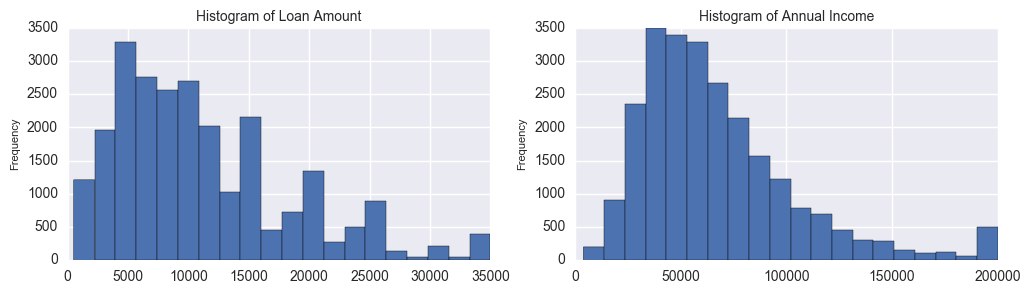

In [17]:
plt.figure(figsize = (12,3))

plt.subplot(1,2,1)
plt.hist(df['Loan Amount'], bins = 20)
plt.ylabel('Frequency', fontsize = 8)
plt.title('Histogram of Loan Amount', fontsize = 10)

plt.subplot(1,2,2)
plt.hist(df['Annual Income'], bins = 20)
plt.ylabel('Frequency', fontsize = 8)
plt.title('Histogram of Annual Income', fontsize = 10)

plt.show()

In Python we can use Pandas to perform plotting but we also have libraries called Matplotlib and Seaborn which create simple visualisation features. Above we have a pair of histograms showing the distributions of loan amounts and annual income. And below the bar chart shows the average credit score for customers type 0 (defaulters) and type 1 (repayers) across a range of loan purposes. It is always quite useful to plot out a few charts to help crystallise the data and what it represents.

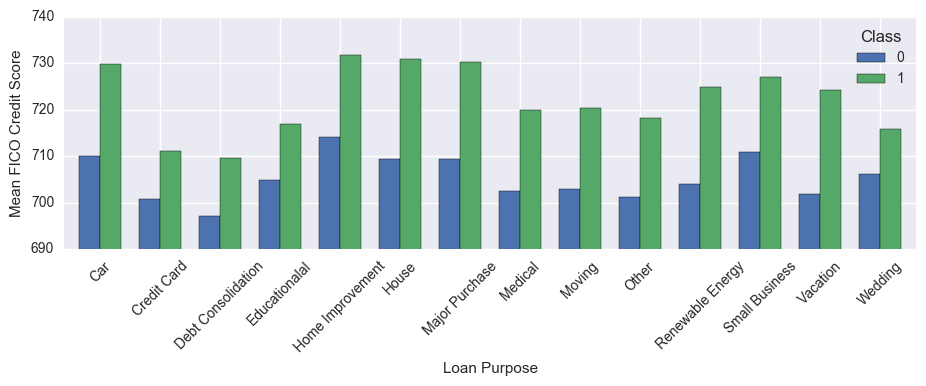

In [18]:
df.groupby(['Loan Purpose', 'Class'])['FICO Credit Score'].mean().unstack().plot(kind = 'bar', figsize = (11,3), width = 0.7)
plt.xticks(rotation = 45)
plt.xlabel('Loan Purpose')
plt.ylabel('Mean FICO Credit Score')
plt.ylim(690, 740)
plt.show()

---

## Predictive Modelling

### Preprocessing

We have spent time cleaning the data and exploring some early relationships between the variables. Our final goal in this notebook however is to build a credit model that will help us determine whether or not to give credit to a customer. We will start by creating a feature matrix X of inputs to feed into the model.

In [19]:
X = df.iloc[:,0:20]

In [20]:
X.corr()

,Loan Amount,Loan Term,Employment Length,Annual Income,Debt To Income Ratio,No. Delinquencies In Last 2 Years,Earliest Credit Line Opened,FICO Credit Score,No. Inquiries In Last 6 Months,Months Since Last Delinquency,No. Of Credit Lines,No. Adverse Public Records,Total Credit Balance,Use Of Credit Line,Total Number Of Credit Lines,Loan Application Description,No. Of Public Record Bankruptcies
Loan Amount,1.000000,0.346452,0.161860,0.419888,0.067194,-0.017880,-0.167322,0.072942,0.031353,-0.025358,0.186612,-0.046217,0.339781,0.076259,0.244136,0.070384,-0.032200
Loan Term,0.346452,1.000000,0.103957,0.075849,0.068526,0.005215,-0.029985,-0.032447,0.055512,0.013403,0.051025,0.004529,0.080432,0.061898,0.101254,-0.023960,0.010151
Employment Length,0.161860,0.103957,1.000000,0.178690,0.057979,0.022638,-0.241920,0.043945,0.015997,0.041946,0.090355,0.050447,0.168096,0.039686,0.203741,-0.099715,0.046222
Annual Income,0.419888,0.075849,0.178690,1.000000,-0.148257,0.031433,-0.279359,0.085643,0.047100,0.023368,0.238596,-0.018320,0.406711,0.027764,0.356283,-0.000482,-0.017091
Debt To Income Ratio,0.067194,0.068526,0.057979,-0.148257,1.000000,-0.015970,-0.019155,-0.240232,0.002697,-0.001325,0.298953,0.001404,0.284208,0.307751,0.225860,-0.022487,0.013626
No. Delinquencies In Last 2 Years,-0.017880,0.005215,0.022638,0.031433,-0.015970,1.000000,-0.072535,-0.210865,-0.003412,0.004255,0.020349,0.009259,-0.058066,-0.030804,0.077041,-0.027236,0.005885
Earliest Credit Line Opened,-0.167322,-0.029985,-0.241920,-0.279359,-0.019155,-0.072535,1.000000,-0.236655,-0.015528,-0.091577,-0.204107,-0.060743,-0.281722,0.041633,-0.378607,0.001181,-0.069481
FICO Credit Score,0.072942,-0.032447,0.043945,0.085643,-0.240232,-0.210865,-0.236655,1.000000,-0.017319,-0.267358,-0.049121,-0.144739,-0.099236,-0.578388,0.088577,0.012036,-0.120587
No. Inquiries In Last 6 Months,0.031353,0.055512,0.015997,0.047100,0.002697,-0.003412,-0.015528,-0.017319,1.000000,0.012117,0.097759,0.020288,-0.018807,-0.084095,0.123051,-0.007543,0.013602
Months Since Last Delinquency,-0.025358,0.013403,0.041946,0.023368,-0.001325,0.004255,-0.091577,-0.267358,0.012117,1.000000,0.042967,0.053624,-0.062771,0.044722,0.095349,-0.018585,0.023249


When compiling features, we wish to eliminate those that are correlated with each other. From the correlation matrix above we see that 'No. Adverse Public Records' and 'No. Of Public Record Bankruptcies' have a high correlation so let's drop one of them from the feature matrix X.

In [21]:
columns_to_drop = ['No. Adverse Public Records']
X = X.drop(columns_to_drop, axis = 1)

Our data contains categorical variables. In essence these are qualitative inputs which the computer struggles to interpret in a numerical framework. They need to be arranged into binary form and populated into a matrix to help the machine process the input factors.

'Home Ownership' has four values - Rent, Mortgage, Own or Other. We can use dummy variables to create four columns that effectively turn these descriptions into binary signals. We also see categorical variables for 'Loan Purpose' and 'Address State'.

In [22]:
X = pd.get_dummies(X)

Next we need to establish our baseline figure. This is the level of accuracy that we would achieve if we gave credit to everybody. In other words it is the percentage we could get without any information.

In [23]:
y = df['Class']

In [24]:
y.value_counts()

1    20243
0     4481
Name: Class, dtype: int64

In [25]:
baseline = y.mean()
if baseline >= 0.5:
    print 'Baseline is', baseline
else:
    print 'Baseline is', 1 - baseline

Baseline is 0.818759100469


When running a machine learning technique we split the data into a train/test split. The training set is used to fit the model. After that we have the testing phase where we see how the model performs with the data that has been 'held out' up until this point.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

### Logistic Regression

Now we are ready to run the modelling. We start by initiating a model, fitting the training data to that model and then using the model to make predictions. It is these predictions that we will assess against the test data.

In [27]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Default parameters C = 1.0, penalty = l2, class_weight = None 

In [28]:
actual_rows = ['Actual 0', 'Actual 1']
predicted_cols = ['Predict 0', 'Predict 1']
pd.DataFrame(confusion_matrix(y_test, y_pred), index = actual_rows, columns = predicted_cols)

,Predict 0,Predict 1
Actual 0,35,1309
Actual 1,29,6045


Here we have the **Confusion Matrix**. There are four possible outcomes.

* True Positive: We predicted a successful outcome and this is what happened.
* False Positive: We predicted a successful outcome but this didn't happen.
* True Negative: We predicted an unsuccessful outcome and this is what happened.
* False Negative: We predicted an unsuccessful outcome score but this didn't happen.

The accuracy score represents the sum of correct outcomes divided by the sum of all the values in the Confusion Matrix. It tells us how often the model is correct.

$$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$

In [29]:
accuracy_score(y_test, y_pred)

0.81962793205715823

Below we have a *Classification Report* where we look at *Precision* and *Recall* scores. Both have positive and negative versions, in contrast to accuracy of which there is only one form. Precision and Recall are useful when we wish to delve a bit deeper into how the model performs.

In [30]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.55      0.03      0.05      1344
          1       0.82      1.00      0.90      6074

avg / total       0.77      0.82      0.75      7418



Metric | Description
--- | ---
Precision + | Of the all the positive predictions, what proportion actually turned out to be positive.
Precision - | Of the all the negative predictions, what proportion actually turned out to be negative.
Recall + | Of the all the positive results, what proportion had been predicted positive.
Recall - | Of the all the negative results, what proportion had been predicted negative.

These values can be computed using the Confusion Matrix and following formulae.

$$Precision_{+} = \frac{TP}{TP+FP}$$

$$Precision_{-} = \frac{TN}{TN+FN}$$

In the report above we see Precision- has a score of 0.55 with Precision+ having a score of 0.82. This means that of the forecasts that were negative (customer not repaying their loan) only 55% turned out to do so. Of the customers forcast to repay the loan, 82% did so. This is quite encouraging.

$$Recall_{+} = \frac{TP}{TP+FN}$$

$$Recall_{-} = \frac{TN}{TN+FP}$$

The Recall- score of 0.03 suggests that of the customers who defaulted in their loan, only 3% had been forecast to do so. Recall+ of 1.00 tells us that nearly all the customers who repaid had been predicted to do so. This disparity is concerning and is often seen for datasets with large class imbalances.

In [31]:
# I'm going to draw a couple of ROC Curves in this exercise so why not write a function to avoid duplication of code.
def print_roc_curve(model):    
    # Get predictions
    y_pred = model.decision_function(X_test)
    # Get rates
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    # Plot the chart
    plt.figure(figsize=[6,4])
    plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc, linewidth = 4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth = 2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (1-Specificity)', fontsize = 10)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 10)
    plt.title('ROC curve', fontsize = 12)
    plt.legend(loc = "lower right")
    plt.show()

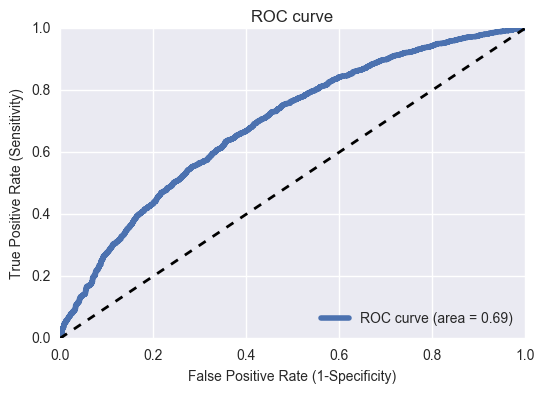

In [32]:
print_roc_curve(lr)

The ROC curve compares the True Positive Rate (TPR) against the False Positive Rate (FPR). The TPR is known as the Sensitivity, or also the Recall Positive which we know from before is TP/(TP+FN). That is, of all the results that were actually positive, what proportion had been predicted to be so? The FPR is defined as 1-Specificity, with Specificity also being the Recall Negative, which we know is TN/(TN+FP). Thus the ROC curve is unaffected by the distribution of class labels since it is only comparing the correct versus incorrect label assignments. The curve is generated by varying a threshold across a range of values and then seeing how the TPR and FPR compare.

While terms such as True Positive Rate and Sensitivity may not be that intuitive, the nature of the graph is quite easy to interpret. We seek to maximise the Area Under the Curve (AUC), and the closer this value is to one the better the classifier is. We look to obtain a line (the solid line above) that will be close to the top left corner of the chart - this will help maximise the AUC. Random guessing the classes would lead to a profile depicted by the dotted line which gives an AUC of 0.5.

### Tuning

When creating a model we need to be mindful of the Bias-Variance tradeoff. If we overfit a model to training data then the model will pay too much attention to the 'noise' and won't perform well when tested on a new sample. Conversely, if the model is underfitted, it will generalise new data well but won't capture enough of the 'signal' to be a useful tool.

To try to get around this we tune the hyperparamters in the model. With Logisitic Regression we have something called Regularisation, which is where we adjust the model strength to try to optimise the model. We have two types - Lasso and Ridge - which can be adjusted with a strength parameter C.

Grid Search is a computationally expensive but useful function. It goes through each combination and scores the model. At the end it produces the nugget *best params* which the user can then go and plug into the model.

In [33]:
%%time
penalties = ['l1','l2']
C_vals = [0.01, 0.05, 0.1, 1.0, 2.5, 5.0, 10.0, 100.0]

gs = GridSearchCV(lr, {'penalty': penalties, 'C': C_vals}, scoring = 'accuracy')
gs.fit(X_train, y_train)

CPU times: user 1min 16s, sys: 1.03 s, total: 1min 17s
Wall time: 1min 4s


In [34]:
gs.best_params_

{'C': 0.05, 'penalty': 'l1'}

In [35]:
# In this cell I have used the parameters from the Grid Search.
# I have also set class_weight to 'balanced'.
# This uses the values of y to automatically adjust weights inversely proportional to class frequencies.

lr_gs = LogisticRegression(penalty = gs.best_params_['penalty'], C = gs.best_params_['C'], class_weight = 'balanced')
lr_gs.fit(X_train, y_train)
y_pred = lr_gs.predict(X_test)

In [36]:
actual_rows = ['Actual 0', 'Actual 1']
predicted_cols = ['Predict 0', 'Predict 1']
pd.DataFrame(confusion_matrix(y_test, y_pred), index = actual_rows, columns = predicted_cols)

,Predict 0,Predict 1
Actual 0,872,472
Actual 1,2024,4050


This confusion matrix looks a little more balanced than before. Ideally we wish to have high numbers in the TN and TP boxes. Here we have 2,024 in the FN box, which is not ideal but at least the model errs on the side of caution - all these people were predicted to default yet paid back their loan. Thankfully the FP box is only 472 - people who were predicted to be creditworthy yet defaulted.

In [37]:
accuracy_score(y_test, y_pred)

0.66352116473442979

In [38]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.30      0.65      0.41      1344
          1       0.90      0.67      0.76      6074

avg / total       0.79      0.66      0.70      7418



In this Classification Report the recall scores are much closer, such that we could say the model adjustments earlier have brought more balance. Of the positive and negative cases, about two-thirds of each had been predicted. Not a great result in absolute terms, but at least we can see how paramter tuning is an influential part of model building.

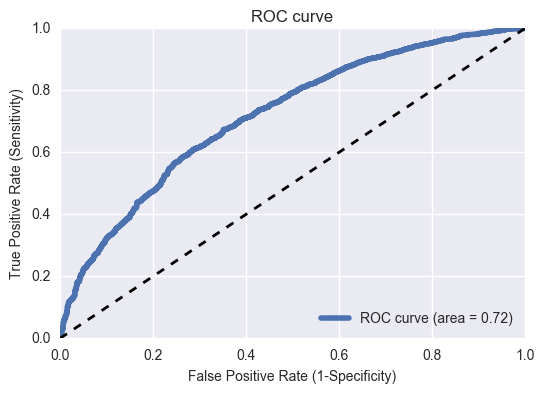

In [39]:
print_roc_curve(lr_gs)

The **Kolmogorov Smirnov Score** is the maximum difference between the cumulative distribution functions of positive and negative responders. If the model has strong predictive power, the positive curve will be significantly higher than the negative and a higher score will ensue. Conversely, a low KS Score will indicate that the positive and negative CDFs are similar and therefore the model is not so good.

In [40]:
stats.ks_2samp(y_test, y_pred)

Ks_2sampResult(statistic=0.20922081423564301, pvalue=5.2036078024161281e-142)

The **Gini coefficient** is a summary statistic of the Lorenz curve and a measure of distribution within a sample. The Gini coefficient is calculated from unordered size data as the relative mean difference i.e. the mean of the difference between every possible pair of individuals divided by the mean size.

In [41]:
def gini(x):
    # Mean Absolute Difference (MAD) using the outer product function.
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative MAD
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [42]:
gini(y_pred)

0.39040172553248853

Finally we obtain the coefficients for the input factors. We see that the 'Loan Purpose' is a key factor in determining the probability of repaying a loan, in particular for credit cards, cars and debt consolidation.

In [43]:
coeffs = [i for x in lr_gs.coef_ for i in x]
results = zip(X.columns, coeffs)
features = pd.DataFrame(results, columns = ['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending = False)
features.head()

,Feature,Coefficient
22,Loan Purpose_Credit Card,0.572548
21,Loan Purpose_Car,0.438868
23,Loan Purpose_Debt Consolidation,0.211054
27,Loan Purpose_Major Purchase,0.083049
49,Address State_IL,0.068528


We also see that with the bottom (negative) factors small businesses may struggle to repay, as is the case for the residents of Nevada, California and Florida.

In [44]:
features.tail()

,Feature,Coefficient
8,No. Inquiries In Last 6 Months,-0.207267
67,Address State_NV,-0.348574
39,Address State_CA,-0.351867
44,Address State_FL,-0.425012
32,Loan Purpose_Small Business,-0.814473


---

## Conclusions

In this workbook we took data from Lending Club and used a Python notebook to perform analysis upon it. There were over 24,000 rows of customer data to investigate.

Firstly we used Python and its libraries to prepare the data for modelling. We used various functions to clean the data and create a contiguous dataframe. Once we had this in place we could create some basic descriptive statisitics and charts.

The goal of this task however was to create a Logistic Regression model for the data. This was done using SciKit Learn, a popular library in Python for machine learning. The model was run with the default parameters and an accuracy score similar to the baseline was achieved. This was accompanied by a huge disparity in the recall scores, which is often observed in cases where there is a class imbalance. In this particular example we found that over 80% of the data was related to customers who successfully paid back their loan. As a result, when the model is being trained, it has limited negative outcomes to be fitted on and thus doesn't really appreciate what causes those defaults. Thus the model simply said "I'll just say everyone (at least, almost everyone) will pay back the loan." Thus we get a positive recall score of nearly 100% and an accuracy equal to the baseline.

On that point I'd also like to mention *Reject Inference*. The data is for customers who have been granted loans. It therefore does not include data for those who were turned down and thus there is a natural bias for credit scoring models generally to have this type of imbalance.

When we played with the class weightings we found that accuracy suffered a little but the recall scores converged to similar values. In fact, we got to the point where using balanced class weights meant that both positive and negative recall were running at around 0.66.

So in summary it was disappointing not to make a model that produced a clear uplift from the baseline. However, post-tuning the model was achieving accuracy and recall scores that were correct two-thirds of the time.